# [7.3 Network in Network (NiN)](https://d2l.ai/chapter_convolutional-modern/nin.html)

paper : [Network In Network (Lin et al. 2013)](https://arxiv.org/abs/1312.4400)

#### Common design pattern of **LeNet**, **AlexNet**, and **VGG** : 
- A sequence of **convolution and pooling layers** (to extract spatial structure) + **fully-connected layers** (to post-process the representations from convolutions)


- Most of parameters are contributed from the fully-connected layers at the end of the network. Dropout is then applied to aviod overfitting. 


### Network in Network (NiN) structure design 

- The original NiN network was proposed shortly after AlexNet. So NiN uses convolutional layers with kernel sizes of 11x11, 5x5, 3x3, and the corresponding numbers of output channels are the same as in AlexNet.


#### 1x1 Convolution

- A **fully connected layer** applied on the **channels** at **each pixel location**. 


- The **NiN** structure is basically a **1x1 convolution layer**. 

<img src='./images/fig_1x1_conv.png' width='400'/>

&emsp;&emsp;&emsp;&emsp;  <sub>* Image Credit : https://forum.perceptilabs.com/t/correct-way-to-specify-a-1x1-convolution/226/2 </sub>


- **1x1 convolution** allows **complex and learnable interactions of cross channel information**, while the **spatial structure** of the intermediate hidden representations are preserved. 


#### Global Average Pooling


- NiN avoids fully-connected layers an the end of the network. -> significantly reduces the number of required model parameters and reduces overfitting.


- NiN uses an NiN block with a number of output channels equal to the number of label classes, followed by a global average pooling layer, yielding a vector of logits.


- The idea is to enforce the network to generate one feature map per channel for each corresponding catagory of the classification task in the last layer. 


#### Architectures of VGG and NiN

<img src='./images/fig_7.3.1.png' width='600'/>

## Implement NiN in PyTorch

In [1]:
import torch
from torch import nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.optim as optim

import matplotlib.pyplot as plt
plt.rc('font', size=16)
import time

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [2]:
def nin_block(in_channels, out_channels, kernel_size, strides, padding):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size, strides, padding),
        nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, kernel_size=1), nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, kernel_size=1), nn.ReLU())

#### ``nn.AdaptiveAvgPool2d(output_size)`` ([doc](https://pytorch.org/docs/stable/generated/torch.nn.AdaptiveAvgPool2d.html)) v.s. ``nn.AvgPool2d(kernel_size, stride=None, padding=0)`` ([doc](https://pytorch.org/docs/stable/generated/torch.nn.AvgPool2d.html?highlight=avgpool2d#torch.nn.AvgPool2d))

- In ``AvgPool2d``, we define a kernel and stride size for the pooling operation, and the function just performs that operation on all valid inputs.



- In ``AdaptiveAvgPool2d``, we define the output size we require at the end of the pooling operation, and pytorch infers what pooling parameters to use to do that.

&emsp;&emsp;&emsp;&emsp; <sub>* reference : https://discuss.pytorch.org/t/adaptive-avg-pool2d-vs-avg-pool2d/27011 <\sub>

In [3]:
net = nn.Sequential(
    nin_block(1, 96, kernel_size=11, strides=4, padding=0),
    nn.MaxPool2d(3, stride=2),
    nin_block(96, 256, kernel_size=5, strides=1, padding=2),
    nn.MaxPool2d(3, stride=2),
    nin_block(256, 384, kernel_size=3, strides=1, padding=1),
    nn.MaxPool2d(3, stride=2), 
    nn.Dropout(0.5),
    # There are 10 label classes
    nin_block(384, 10, kernel_size=3, strides=1, padding=1),
    nn.AdaptiveAvgPool2d((1, 1)),
    # Transform the four-dimensional output into two-dimensional output with a
    # shape of (batch size, 10)
    nn.Flatten())

net.to(device)

# count total network parameters
print('Total network parameters :', sum(param.numel() for param in net.parameters() if param.requires_grad))

Total network parameters : 1992166


In [4]:
X = torch.rand(size=(1, 1, 224, 224)).to(device)

for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 96, 54, 54])
MaxPool2d output shape:	 torch.Size([1, 96, 26, 26])
Sequential output shape:	 torch.Size([1, 256, 26, 26])
MaxPool2d output shape:	 torch.Size([1, 256, 12, 12])
Sequential output shape:	 torch.Size([1, 384, 12, 12])
MaxPool2d output shape:	 torch.Size([1, 384, 5, 5])
Dropout output shape:	 torch.Size([1, 384, 5, 5])
Sequential output shape:	 torch.Size([1, 10, 5, 5])
AdaptiveAvgPool2d output shape:	 torch.Size([1, 10, 1, 1])
Flatten output shape:	 torch.Size([1, 10])


/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [5]:
net

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 96, kernel_size=(11, 11), stride=(4, 4))
    (1): ReLU()
    (2): Conv2d(96, 96, kernel_size=(1, 1), stride=(1, 1))
    (3): ReLU()
    (4): Conv2d(96, 96, kernel_size=(1, 1), stride=(1, 1))
    (5): ReLU()
  )
  (1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (2): Sequential(
    (0): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (3): ReLU()
    (4): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (5): ReLU()
  )
  (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(384, 384, kernel_size=(1, 1), stride=(1, 1))
    (3): ReLU()
    (4): Conv2d(384, 384, kernel_size=(1, 1), stride=(1, 1))
    (5): ReLU()
  )
  (5): MaxPool2d(kernel_size=3, stri

In [6]:
### Load FashionMNIST dataset and apply data transform, make input dimension 28x28 -> 224x224

transform = transforms.Compose([transforms.Resize([224, 224]),
                                transforms.RandomHorizontalFlip(),
                                transforms.ToTensor()])

fmnist_train = datasets.FashionMNIST(
    root="../../../data", train=True, transform=transform, download=True)
fmnist_test = datasets.FashionMNIST(
    root="../../../data", train=False, transform=transform, download=True)

batch_size = 64

train_loader = DataLoader(fmnist_train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(fmnist_test, batch_size=batch_size, shuffle=True)

images, labels = next(iter(train_loader))
images.shape

/usr/local/lib/python3.8/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


torch.Size([64, 1, 224, 224])

In [7]:
### Loss function
criterion = nn.CrossEntropyLoss()

In [8]:
### Optimizer
learning_rate = 0.0001

# optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate)
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate, betas=(0.9, 0.999))

In [9]:
### Training function

def train_1_epoch(model, optimizer, train_loss, train_acc):
    
    model.train()             # set model to training mode

    running_loss = 0.
    running_corrects = 0
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device) 
        labels = labels.to(device)
        
        # forward
        outputs = model(images)
        
        # loss
        loss = criterion(outputs, labels) # predicted outputs v.s. actual labels
        
        # backwards
        optimizer.zero_grad()  # zero gradient
        loss.backward()        # loss.backward would calculate dloss/dw_i  
        optimizer.step()       # update network parameters (w_i)
        
        # compute statistics (avg. loss, accuracy)
        running_loss += loss.item() * labels.size(0)
        _, predictions = torch.max(outputs, 1)
        running_corrects += torch.sum(predictions == labels.data)
        
        #if (i+1)%300 == 0: # every 300 steps, print something
        #    print(f'epoch {epoch+1}/{num_epochs}, step {i+1}/{len(train_loader)}, loss={loss.item():.4f}')
            
    epoch_loss = running_loss / len(fmnist_train)            ; train_loss.append(epoch_loss)
    epoch_acc  = running_corrects / len(fmnist_train) * 100. ; train_acc.append(epoch_acc)
    print(f'>>> End epoch {epoch+1}, train accuracy = {epoch_acc:.2f}%, train avgLoss = {epoch_loss:.4f}')

    
    
def validation(model, valid_loss, valid_acc):
    
    model.eval()              # set model to evaluation mode
    
    running_loss = 0.
    running_corrects = 0
    
    for i, (images, labels) in enumerate(test_loader):
        
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        
        loss = criterion(outputs, labels)
        
        # compute statistics (avg. loss, accuracy)
        running_loss += loss.item() * labels.size(0)
        _, predictions = torch.max(outputs, 1)
        running_corrects += torch.sum(predictions == labels.data)
    
    valid_loss.append(running_loss/len(test_loader.dataset))
    valid_acc.append(running_corrects/len(test_loader.dataset) * 100.)
    print(f'>>>              valid accuracy = {valid_acc[-1]:.2f}%, valid avgLoss = {valid_loss[-1]:.4f}')

In [10]:
train_loss = []
train_acc = []
valid_loss = []
valid_acc = []

num_epochs = 10
for epoch in range(0, num_epochs):
    since = time.time()
    
    train_1_epoch(net, optimizer, train_loss, train_acc)
    validation(net, valid_loss, valid_acc)
    
    time_elapsed = time.time() - since
    print(f'\tTime: {time_elapsed//60:.0f}m {time_elapsed%60:.0f}s')

>>> End epoch 1, train accuracy = 38.68%, train avgLoss = 1.6603
>>>              valid accuracy = 67.24%, valid avgLoss = 0.9370
	Time: 0m 59s
>>> End epoch 2, train accuracy = 71.39%, train avgLoss = 0.7975
>>>              valid accuracy = 74.09%, valid avgLoss = 0.7312
	Time: 0m 59s
>>> End epoch 3, train accuracy = 75.21%, train avgLoss = 0.6777
>>>              valid accuracy = 74.71%, valid avgLoss = 0.6797
	Time: 0m 59s
>>> End epoch 4, train accuracy = 77.49%, train avgLoss = 0.6137
>>>              valid accuracy = 78.16%, valid avgLoss = 0.5958
	Time: 0m 60s
>>> End epoch 5, train accuracy = 79.43%, train avgLoss = 0.5659
>>>              valid accuracy = 80.80%, valid avgLoss = 0.5400
	Time: 0m 59s
>>> End epoch 6, train accuracy = 80.93%, train avgLoss = 0.5302
>>>              valid accuracy = 80.87%, valid avgLoss = 0.5287
	Time: 0m 59s
>>> End epoch 7, train accuracy = 81.91%, train avgLoss = 0.5052
>>>              valid accuracy = 82.58%, valid avgLoss = 0.4900
	Time:

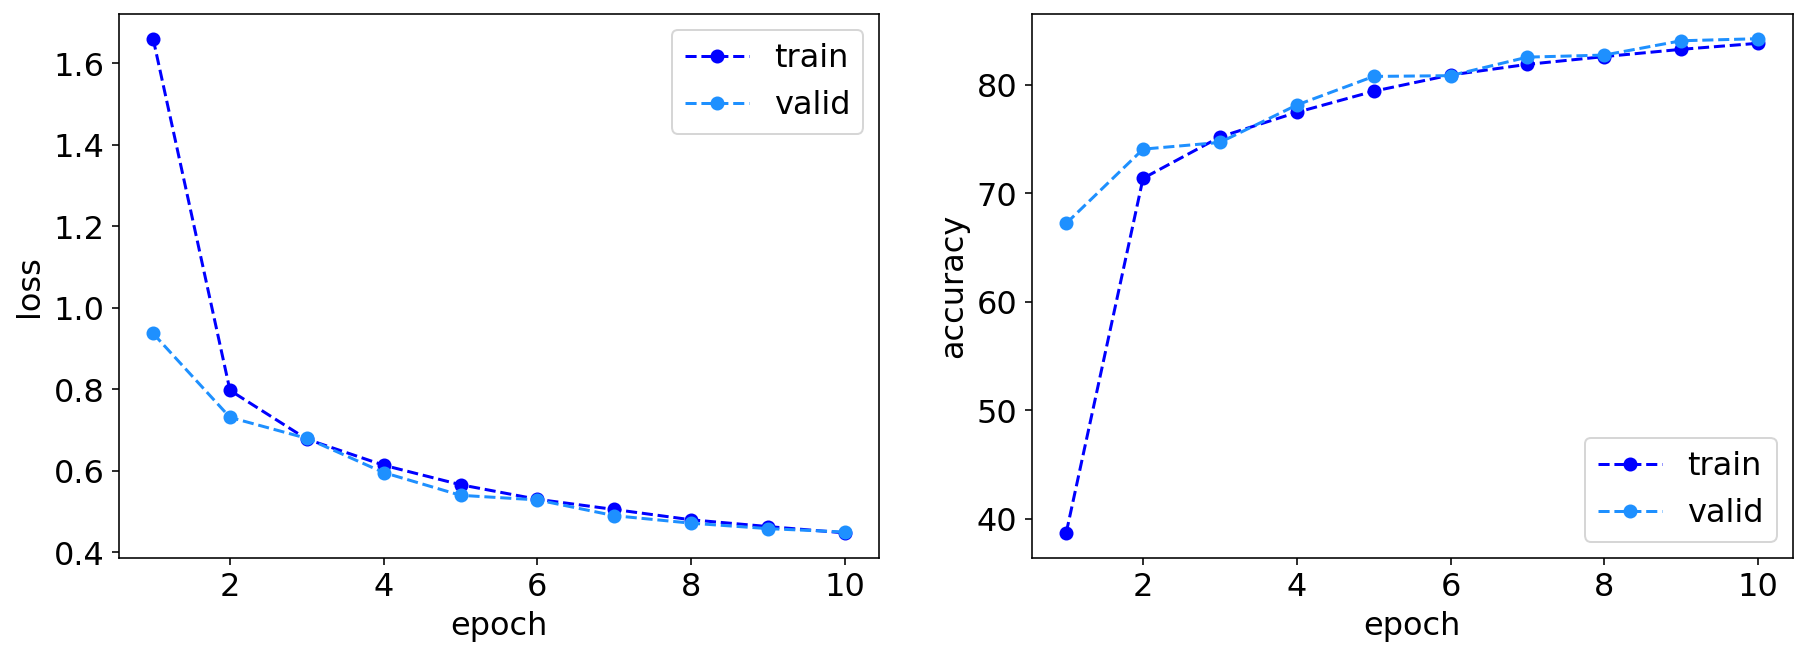

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
plt.rc('font', size=16)

ax[0].plot(range(1,num_epochs+1)[::], train_loss[::], 'o--', label='train', color='b')
ax[0].plot(range(1,num_epochs+1)[::], valid_loss[::], 'o--', label='valid', color='dodgerblue')
ax[1].plot(range(1,num_epochs+1)[::], train_acc[::] , 'o--', label='train', color='b')
ax[1].plot(range(1,num_epochs+1)[::], valid_acc[::], 'o--', label='valid', color='dodgerblue')

ax[0].set_ylabel('loss')
ax[1].set_ylabel('accuracy')

for i in range(2):
    ax[i].set_xlabel('epoch')
    ax[i].legend(loc='best')